#### Data can be downloaded [here](https://digital.wpi.edu/concern/student_works/5712m8080?locale=en)
1. Scroll to the bottom of the page
2. Download the ASLMQP.zip file into a `Data` directory inside of your parent directory
3. Unzip it into the `Data` directory!

The sheet you're looking for is `Accuscore Evaluation.xlsx`

In [ ]:
# import packages and dataset
import pandas as pd

# These were imported for each fantasy football position type (QB or DST)
QB = pd.read_excel('../Data/Accuscore Evaluation.xlsx', sheet_name='QB Projections')
DST = pd.read_excel('../Data/Accuscore Evaluation.xlsx', sheet_name= 'DST Projections')

# Data Cleaning

In [18]:
# Remove duplicate columns (PLAYERID/ESPNID is simply an alias for PLAYER)
QB = QB.drop(['PLAYERID', 1], axis=1)
# Since defenses are played per team, as long as we have the TEAM data, we know what the name of the player is
DST = DST.drop(['ESPNID', 'PLAYER'], axis=1)
# Rename ORDER column to WEEK for clarity (since order describes the week of the NFL season)
QB = QB.rename(columns={'ORDER':'WEEK'})
DST = DST.rename(columns={'ORDER':'WEEK'})


# Remove Ben Roethelisberger's and Andrew Luck's bye weeks (Week 4), since the authors forgot to
ben_bye = ((QB['WEEK'] == 4) & (QB['PLAYER'] == 'Ben Roethlisberger')).astype(int).idxmax()
luck_bye = ((QB['WEEK'] == 4) & (QB['PLAYER'] == 'Andrew Luck')).astype(int).idxmax()
QB = QB.drop([ben_bye, luck_bye], axis=0)


In [19]:
# Print out the shape of each dataset
print(QB.shape)
print(DST.shape)

(585, 27)
(480, 25)


#### How does the shape of each dataset relate to the number of features and observations in that dataset?
- QBs
    - There are 32 teams in the NFL
    - There were 585 datapoints for projections on 39 different quarterbacks across the 16-week 2012 season (15 games played for each player + 1 bye week)
    - The reason there are more than 32 quarterbacks is because multiple teams had more than two quarterbacks that started at least 1 game across the season
    - Thus, there are 39*15 = 585 rows in this dataset
- DSTs
    - There are 32 teams, and thus 32 team defenses, in the NFL
    - There are 480 datapoints for projections on these 32 team defeneses across the 16-week 2013 season
    - This is because each team gets a __bye week__ where they don't play. 
    - For defenses, these weeks were excluded from the dataset. Therefore, there are 32 teams * 15 weeks = 480 datapoints
- Features
    - There are 21 projections (16 in-season projections + 5 preseason ones) + a 'variation' column that measures the variance in projections from week to week for each player
    - Other columns track player, team, and week information

In [20]:
# Feature 1: Player/Team
# Expectations included in the description above
print(QB['PLAYER'].describe())
print()
print(DST['TEAM'].describe())
print()

# Feature 2: Actuals (Fantasy points scored)
# I would expect quarterbacks to score, on average, 15 fantasy points. All rows should have a value for this measure
print(QB['Actuals'].describe())
# In actuality, they scored about 13 fantasy points on average, which is lower than I expected.
print()
# I would expect team defenses to score, on average, 8 fantasy points. All rows should have a value for this measure
print(DST['Actuals'].describe())
# In actuality, they scored about 10 fantasy points on average, which is higher than I expected.

count                585
unique                39
top       Peyton Manning
freq                  15
Name: PLAYER, dtype: object

count     480
unique     32
top       ATL
freq       15
Name: TEAM, dtype: object

count    585.000000
mean      12.507316
std        9.307847
min       -4.840000
25%        3.840000
50%       13.040000
75%       18.860000
max       39.400000
Name: Actuals, dtype: float64

count    480.000000
mean      10.543750
std        9.213664
min       -4.000000
25%        4.000000
50%        8.000000
75%       15.000000
max       51.000000
Name: Actuals, dtype: float64


## Section 3: Figure 1 (Player/Team)
#### Describe what kind of visualization you want to make.
I would like to make a histogram of how many observations occur for each player in the sample.
#### Why is this appropriate for this feature and data set?
This is appropriate as a way to verify that there are 15 observations per player, and track how many observations occur for each player in the sample
#### How will the visualization provide insight into the data?
This figure adds more context to the describe output, since every player in the entire sample has 15 observations. This is a key insight, especially considering that not all of the QBs in the sample played or were expected to play in all 15 of their games.
- Blaine Gabbert, for example, only played in 10 games in 2012

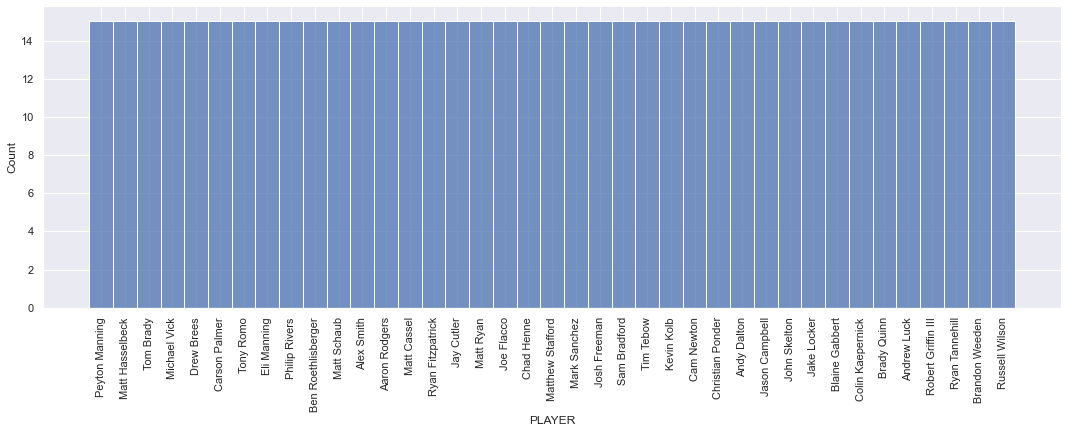

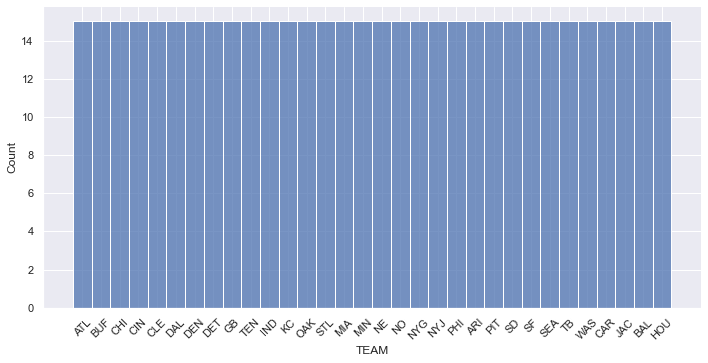

In [22]:
# Provide code and explain your code to make the visualization.

# Import seaborn and set the theme
import seaborn as sns
sns.set_theme()
# Make a very wide plot, listing each QB on the x-axis with their name rotated 90° for readability
# The counts axis will represent the number of games tracked for that QB
bar_QBs = sns.displot(data=QB, x='PLAYER', aspect=3)
display(bar_QBs.set_xticklabels(rotation=90))

# Make a wide plot, listing each D/ST on the x-axis with their name rotated 45° for readability
# The counts axis will represent the number of games tracked for that D/ST
bar_DSTs = sns.displot(data=DST, x='TEAM', aspect=2)
display(bar_DSTs.set_xticklabels(rotation=45))


#### Interpret the visualization: compare it to the "describe" function output from Section 2
This figure confirms what the `describe` function's output only implies; if the most frequently observed quarterback (Peyton Manning) was observed 15 times, and there are 39 unique quarterbacks and 585 total samples, then each quarterback must have 585/39 = 15 observations. 
#### Explain what insight into the data you can make with the visualization. 
All quarterbacks in the model were included for all weeks, regardless of whether or not they were projected to play.
#### Describe how your visualization relates to one of the hypotheses or figures from the paper.
If the authors were trying to evaluate how good their model was at predicting fantasy points scored, weeks where a player was injured (and thus would have been projected to score 0 points)
are just free wins for the model, and would artificially boost any measure of how good the model was at predicting fantasy points

## Section 3: Figure 2 (Actual Fantasy Points Scored)
#### Describe what kind of visualization you want to make.
I would like to make a histogram of how many fantasy points are scored for QBs and D/STs.
#### Why is this appropriate for this feature and data set?
This plot is appropriate fantasy points are a numerical metric that can be divided up into bins to determine how good (or bad) a performance was, relative to the average
#### How will the visualization provide insight into the data?
This figure will provide a baseline for what a `good` fantasy game was for each position in 2012, which will help us qualitatively evaluate the model's projections
- For example, if the average defense scored 10 fantasy points, and most defenses scored less than 15 points, it would be highly unlikely that the model would project a defense to score more than 15 fantasy points

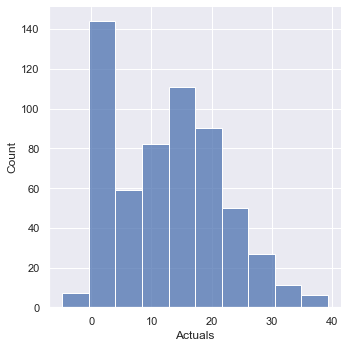

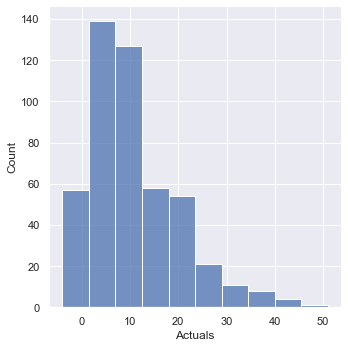

In [78]:
# Figure 2: Fantasy Points Scored. Histogram of how many points each position scores
point_QBs = sns.displot(data=QB, x='Actuals', bins=10)
display(point_QBs)
point_DSTs = sns.displot(data=DST, x='Actuals', bins=10)
display(point_DSTs)

# Additional insights: Quarterback scoring demonstrates a normal distr

#### Interpret the visualization: compare it to the "describe" function output from Section 2
This figure is a visualization of the `describe` function's output; both QB and D/ST scoring are right-skewed, with 75% of the data for QB and D/ST lying below the half of the maximum score at each position
- For QBs, the maximum score (from the describe output) was **39.4** fantasy points. The 75th percentile score was **18.86** fantasy points
- For D/STs, the maximum score (from the describe output) was **51** fantasy points. The 75th percentile score was **15** fantasy points 
#### Explain what insight into the data you can make with the visualization. 
Quarterback fantasy point scoring follows more of a Normal distribution (plus a bunch of 0 scores for weeks where those QBs didn't play). D/ST fantasy point scoring, however, is truly right-skewed. The majority of fantasy defenses score below ~12 fantasy points.
#### Describe how your visualization relates to one of the hypotheses or figures from the paper.
Knowing how fantasy point scoring is distributed for each position can help the authors find appropriate models to predict future fantasy point scoring at each position. It's also helpful to know that the fantasy points scored distribution is different for different positions. That suggests that a different model should probably be used to project each position's future fantasy points.